## Second version for the EWC Notebook

The idea is to try to start from scratch and adapt the code to the data. 

We will for instance try:
- Velocity as a target
- Not normalizing the target
- Start with basic model and add layers if I see it improves
- Do not check outliers here

### Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
date = '0504'
target_variable = 'target_vel'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path = './Data/Processed_Data/Tidy_Sansa_0504Clean.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [9]:
tonic_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [10]:
stim_df = tidy_df.loc[tidy_df.type == 'BC-REACH'].reset_index()

## Get train-val-test split

In [11]:
fold = 0

In [12]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= target_variable, no_outliers = False)

Test trials  6
Val trials 4
We are testing the optimization method on fold  0


In [13]:
xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim,\
      xx_test_stim, yy_test_stim, info_train_stim, info_val_stim,\
          info_test_stim,  list_mins_stim, \
            list_maxs_stim = get_dataset(tonic_df, fold, target_variable= target_variable, no_outliers = False)

Test trials  7
Val trials 6
We are testing the optimization method on fold  0


In [14]:
xx_train_bcr, yy_train_bcr, xx_val_bcr, yy_val_bcr,\
      xx_test_bcr, yy_test_bcr, info_train_bcr,\
          info_val_bcr, info_test_bcr,  list_mins_bcr,\
              list_maxs_bcr = get_dataset(stim_df, fold, no_outliers = False)

Test trials  14
Val trials 11
We are testing the optimization method on fold  0


In [15]:
xx_train_all, yy_train_all, xx_val_all, yy_val_all, \
    xx_test_all, yy_test_all, info_train_all, \
    info_val_all, info_test_all,  list_mins_all,\
          list_maxs_all = get_dataset(tidy_df,fold, target_variable= target_variable, no_outliers = False)

Test trials  26
Val trials 21


We are testing the optimization method on fold  0


In [16]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models'

# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

In [17]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [18]:
def reshape_to_eval(x,y, model):
    # Convert X_train and y_train to PyTorch tensors
    inputs = torch.tensor(x, device=device, dtype=torch.float32)
    targets = torch.tensor(y, device=device, dtype=torch.float32)

    y_pred = model(inputs)
    y_array = targets.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D



def eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'rmse'):

    #Move tensors to cpu and reshape them for evaluation
    y_true_train, y_pred_train = reshape_to_eval(xx_train,yy_train, model)
    y_true_val, y_pred_val = reshape_to_eval(xx_val,yy_val, model)
    y_true_test, y_pred_test = reshape_to_eval(xx_test,yy_test, model)

    if metric == 'rmse':
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(y_true_train, y_pred_train))
        print('Train Score: %.2f RMSE' % (trainScore))
        valScore = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
        print('Val Score: %.2f RMSE' % (valScore))
        testScore = math.sqrt(mean_squared_error(y_true_test, y_pred_test))
        print('Test Score: %.2f RMSE' % (testScore))

        return y_pred_val, y_true_val,trainScore, valScore, testScore
    
    elif metric == 'ev':
        #Compute explained variance
        ev_train = explained_variance_score(y_true_train, y_pred_train)
        ev_val = explained_variance_score(y_true_val, y_pred_val)
        ev_test = explained_variance_score(y_true_test, y_pred_test)
        print('Train EV: %.2f ' % (ev_train))
        print('Val EV: %.2f ' % (ev_val))
        print('Test EV: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test
    
    elif metric == 'r2':
        #Compute explained variance
        ev_train = r2_score(y_true_train, y_pred_train)
        ev_val = r2_score(y_true_val, y_pred_val)
        ev_test = r2_score(y_true_test, y_pred_test)
        print('Train R2: %.2f ' % (ev_train))
        print('Val R2: %.2f ' % (ev_val))
        print('Test R2: %.2f ' % (ev_test))
        return y_pred_val, y_true_val, ev_train, ev_val, ev_test

## Baseline Model

In [19]:
class Model(nn.Module):
    def __init__(self, num_features=124, 
                hidden_units= 3, #was 128
                num_layers = 2, 
                input_size = 50,
                out_dims = 6,
                dropout = 0.5):
        super(Model, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.out_dims = out_dims
        self.dropout = dropout

        self.rnn = nn.RNN(
            input_size = self.num_features, 
            hidden_size = self.hidden_units, 
            num_layers = self.num_layers, 
            nonlinearity='tanh', bias= True, 
            batch_first= True, dropout=0.0, 
            bidirectional=False,) 
        
        """ self.lstm = nn.LSTM(
            input_size= self.num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,) """
        
        self.selu = nn.SELU()
    
        self.linear = nn.Linear(in_features=self.hidden_units, out_features= self.out_dims)

        self.dropout = nn.Dropout(p= dropout) #trial.suggest_float('dropout_1', 0.1, 0.9)
        
        # Flatten the parameters
        self.rnn.flatten_parameters()

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.selu(x) 
        output = self.linear(x)
        
        return output.squeeze()

#### Adding noise to the training data

In [20]:
# Add Gaussian noise to input features
xx_train_base = torch.tensor(xx_train_base, dtype=torch.float32) + torch.tensor(np.random.normal(loc=0, scale=0.075, size=xx_train_base.shape), dtype=torch.float32)

In [21]:
def Regularizer_LSTM_test(model, alpha=1e-5, l1_ratio=0.5):
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: CausalTemporalLSTM instance
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    w_t = model.lstm.weight_ih_l0
    w_l = model.linear.weight
   

    l1_loss = w_t.abs().sum() + w_l.abs().sum() 
    l2_loss = w_t.pow(2.0).sum() + w_l.pow(2.0).sum() 

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    return reg.item()

In [22]:
''' Hyper Baseline'''

# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5

l1_ratio_reg = 0.5

lr = 1e-5
loss_function = huber_loss
huber_delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 300
num_layers = 1
dropout = 0.2

#Other training hyperparameters

lr_gamma= 0.9 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 15
batch_size_train= 15
batch_size_val = 15

In [23]:
# Fit the LSTM model
model_base = Model(num_features=num_features, 
                hidden_units= n_hidden_units, #was 128
                num_layers = num_layers, 
                out_dims = num_dim_output,
                dropout = dropout).to(device)

model_base.apply(weight_reset)

Model(
  (rnn): RNN(128, 300, batch_first=True)
  (selu): SELU()
  (linear): Linear(in_features=300, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [24]:
train_losses, val_losses = \
    train_model(model_base, 
                xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= Regularizer_RNN, # Regularizer_LSTM_test,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5)

/home/nerea/CL_UpperLimb_Control/src/trainer.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


Epoch 000 Train 0.1487 Val 0.1086
Epoch 001 Train 0.1233 Val 0.0917
Epoch 002 Train 0.1035 Val 0.0775
Epoch 003 Train 0.0854 Val 0.0642
Epoch 004 Train 0.0682 Val 0.0521
Epoch 005 Train 0.0520 Val 0.0420
Epoch 006 Train 0.0388 Val 0.0365
Epoch 007 Train 0.0327 Val 0.0327
Epoch 008 Train 0.0294 Val 0.0297
Epoch 009 Train 0.0274 Val 0.0279
Epoch 010 Train 0.0257 Val 0.0261
Epoch 011 Train 0.0245 Val 0.0249
Epoch 012 Train 0.0234 Val 0.0239
Epoch 013 Train 0.0224 Val 0.0228
Epoch 014 Train 0.0214 Val 0.0219
Epoch 015 Train 0.0206 Val 0.0211
Epoch 016 Train 0.0200 Val 0.0205
Epoch 017 Train 0.0193 Val 0.0198
Epoch 018 Train 0.0188 Val 0.0194
Epoch 019 Train 0.0181 Val 0.0189
Epoch 020 Train 0.0177 Val 0.0184
Epoch 021 Train 0.0173 Val 0.0180
Epoch 022 Train 0.0170 Val 0.0178
Epoch 023 Train 0.0167 Val 0.0174
Epoch 024 Train 0.0163 Val 0.0171
Epoch 025 Train 0.0161 Val 0.0168
Epoch 026 Train 0.0158 Val 0.0166
Epoch 027 Train 0.0155 Val 0.0164
Epoch 028 Train 0.0153 Val 0.0162
Epoch 029 Trai

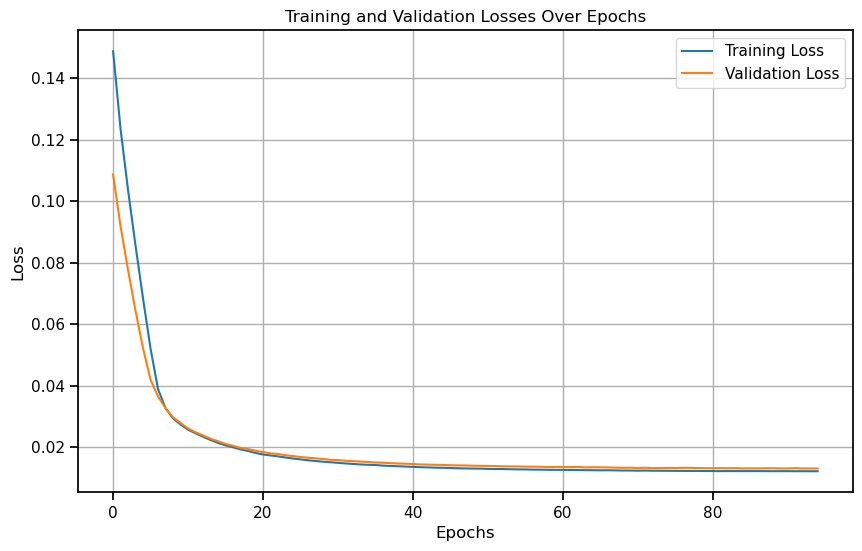

In [25]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [26]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_base, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Baseline'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_base, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [27]:
""" model_baselineonly = torch.load(path_to_save_model_fold)
model_baselineonly.eval() """

' model_baselineonly = torch.load(path_to_save_model_fold)\nmodel_baselineonly.eval() '

In [28]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base, metric = 'ev')

Train EV: 0.15 
Val EV: 0.18 
Test EV: 0.15 


/tmp/ipykernel_25793/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


In [29]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base, metric = 'r2')

Train R2: 0.15 
Val R2: 0.17 
Test R2: -6.78 


/tmp/ipykernel_25793/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


In [30]:
y_true_train, y_pred_train = reshape_to_eval(xx_train_base,yy_train_base, model_base)

/tmp/ipykernel_25793/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


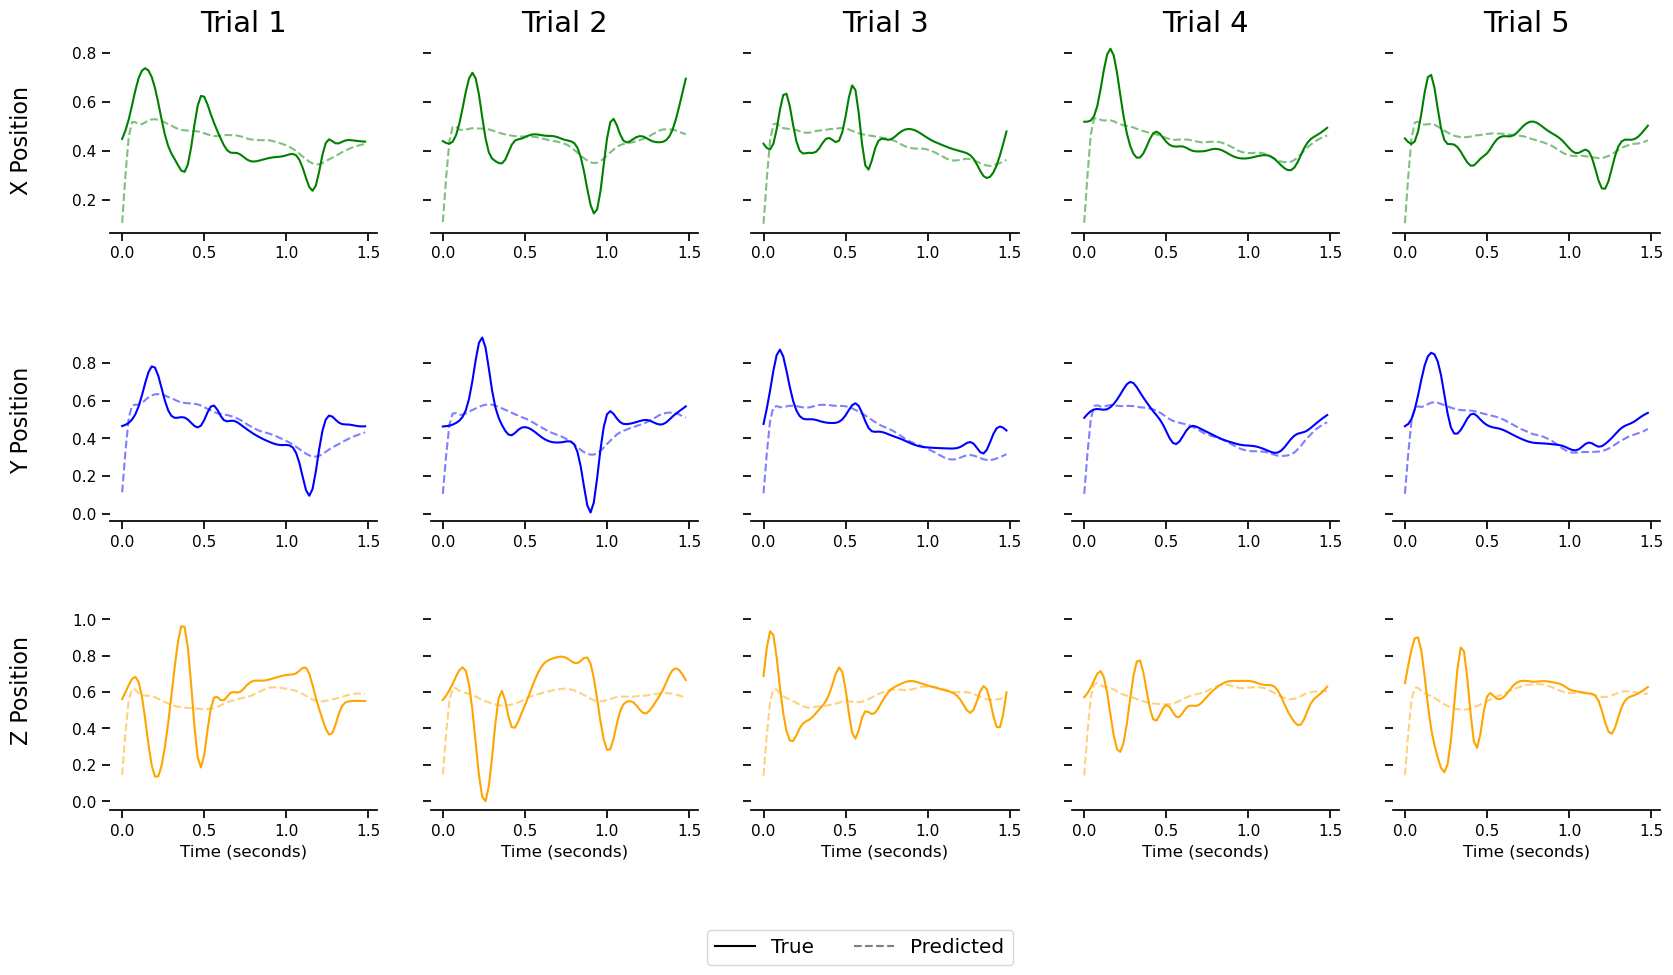

In [31]:
visualize_LSTM_test(y_pred_train, y_true_train, seq_length = 75)

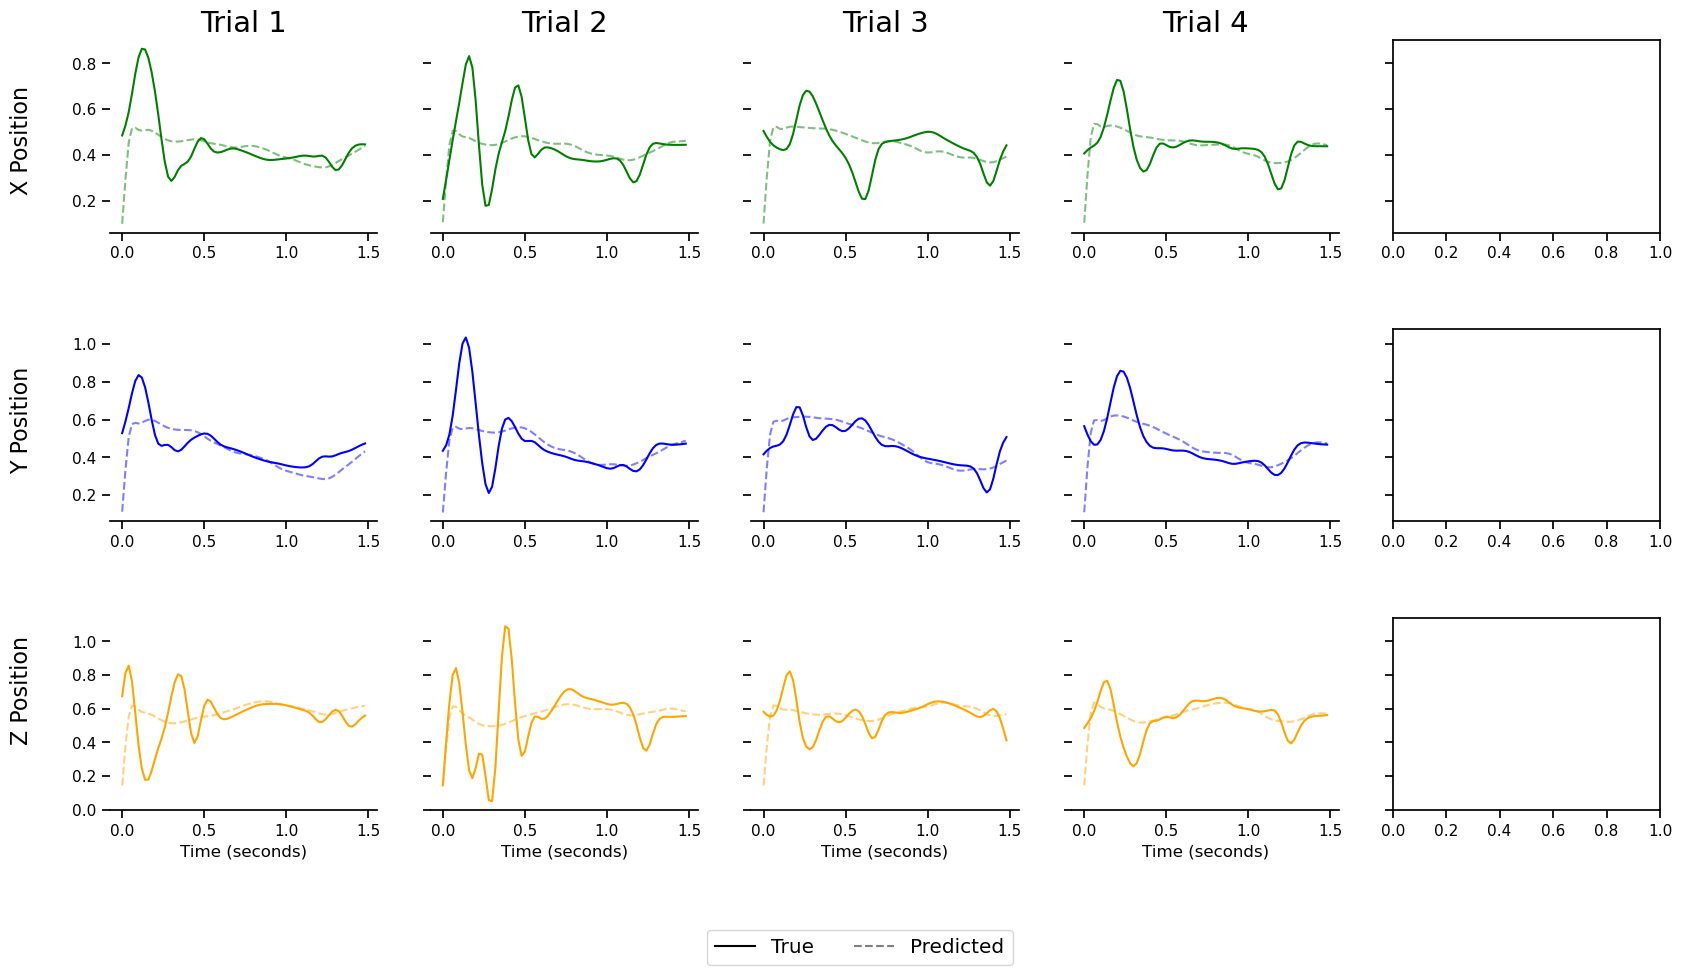

In [32]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Testing the model on stimulation data

In [33]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base, metric = 'ev')

Train EV: 0.13 
Val EV: 0.19 
Test EV: 0.10 


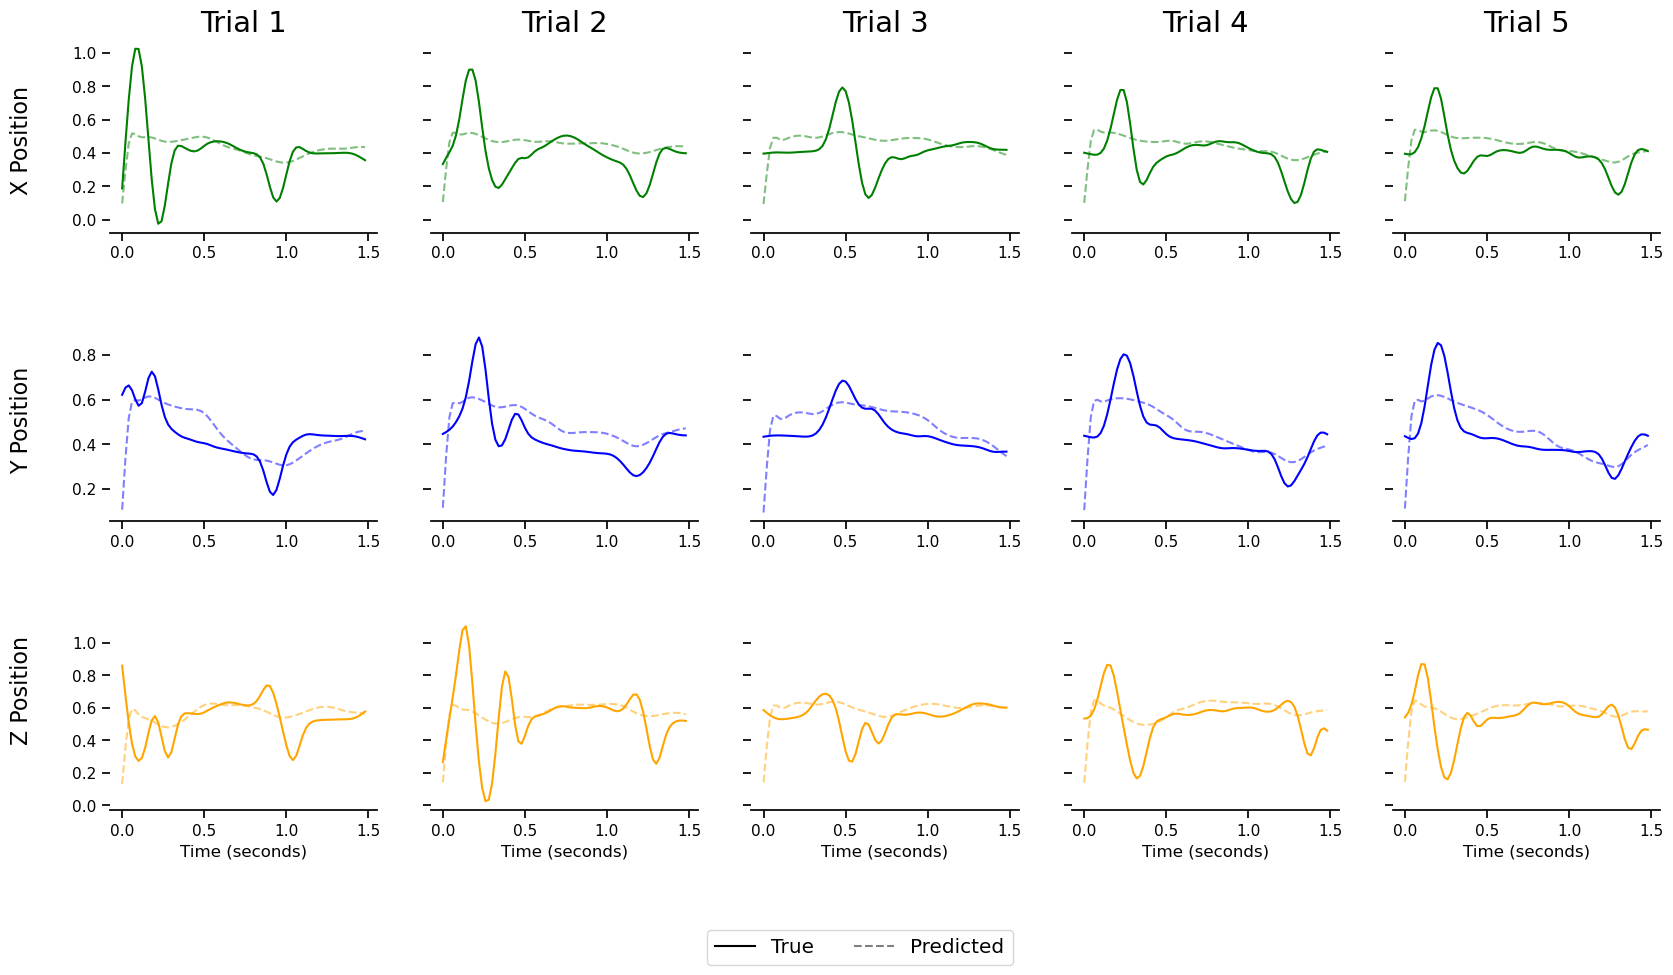

In [34]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Now we use all data for training

In [35]:
# Fit the LSTM model
model_all = Model(num_features=num_features, 
                hidden_units= n_hidden_units, #was 128
                num_layers = num_layers, 
                input_size = input_size_LSTM,
                out_dims = num_dim_output).to(device)
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_all.apply(weight_reset)

NameError: name 'input_size_LSTM' is not defined

In [ ]:
train_losses, val_losses = \
    train_model(model_all, xx_train_all,yy_train_all,
                xx_val_all, 
                yy_val_all,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0378 Val 0.0174
Epoch 001 Train 0.0284 Val 0.0147
Epoch 002 Train 0.0244 Val 0.0136
Epoch 003 Train 0.0220 Val 0.0130
Epoch 004 Train 0.0200 Val 0.0126
Epoch 005 Train 0.0187 Val 0.0123
Epoch 006 Train 0.0175 Val 0.0122
Epoch 007 Train 0.0165 Val 0.0120
Epoch 008 Train 0.0157 Val 0.0119
Epoch 009 Train 0.0150 Val 0.0119
Epoch 010 Train 0.0143 Val 0.0118
Epoch 011 Train 0.0138 Val 0.0117
Epoch 012 Train 0.0133 Val 0.0118
Epoch 013 Train 0.0129 Val 0.0117
Epoch 014 Train 0.0125 Val 0.0116
Epoch 015 Train 0.0122 Val 0.0116
Epoch 016 Train 0.0119 Val 0.0115
Epoch 017 Train 0.0115 Val 0.0116
Epoch 018 Train 0.0112 Val 0.0115
Epoch 019 Train 0.0110 Val 0.0116
Epoch 020 Train 0.0107 Val 0.0115
Epoch 021 Train 0.0105 Val 0.0115
Epoch 022 Train 0.0103 Val 0.0115
Epoch 023 Train 0.0101 Val 0.0115
Epoch 024 Train 0.0099 Val 0.0115
Epoch 025 Train 0.0097 Val 0.0114
Epoch 026 Train 0.0095 Val 0.0115
Epoch 027 Train 0.0094 Val 0.0115
Epoch 028 Train 0.0092 Val 0.0115
Epoch 029 Trai

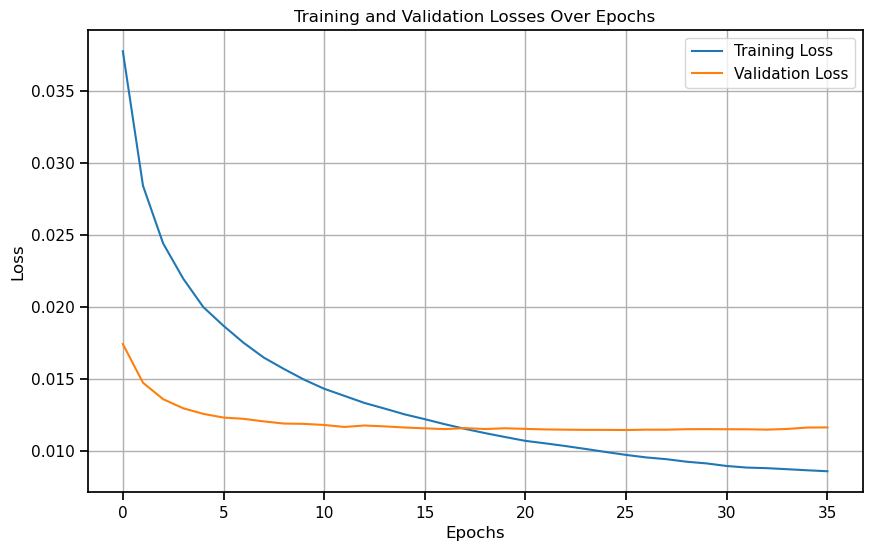

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Alldata'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_all, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Alldata'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_all, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [ ]:
""" model_all_data = torch.load(path_to_save_model_fold)
model_all_data.eval() """

' model_all_data = torch.load(path_to_save_model_fold)\nmodel_all_data.eval() '

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_all, yy_train_all, xx_val_all, yy_val_all, xx_test_all, yy_test_all, model_all, metric = 'ev')

Train EV: 0.67 
Val EV: 0.57 
Test EV: 0.53 


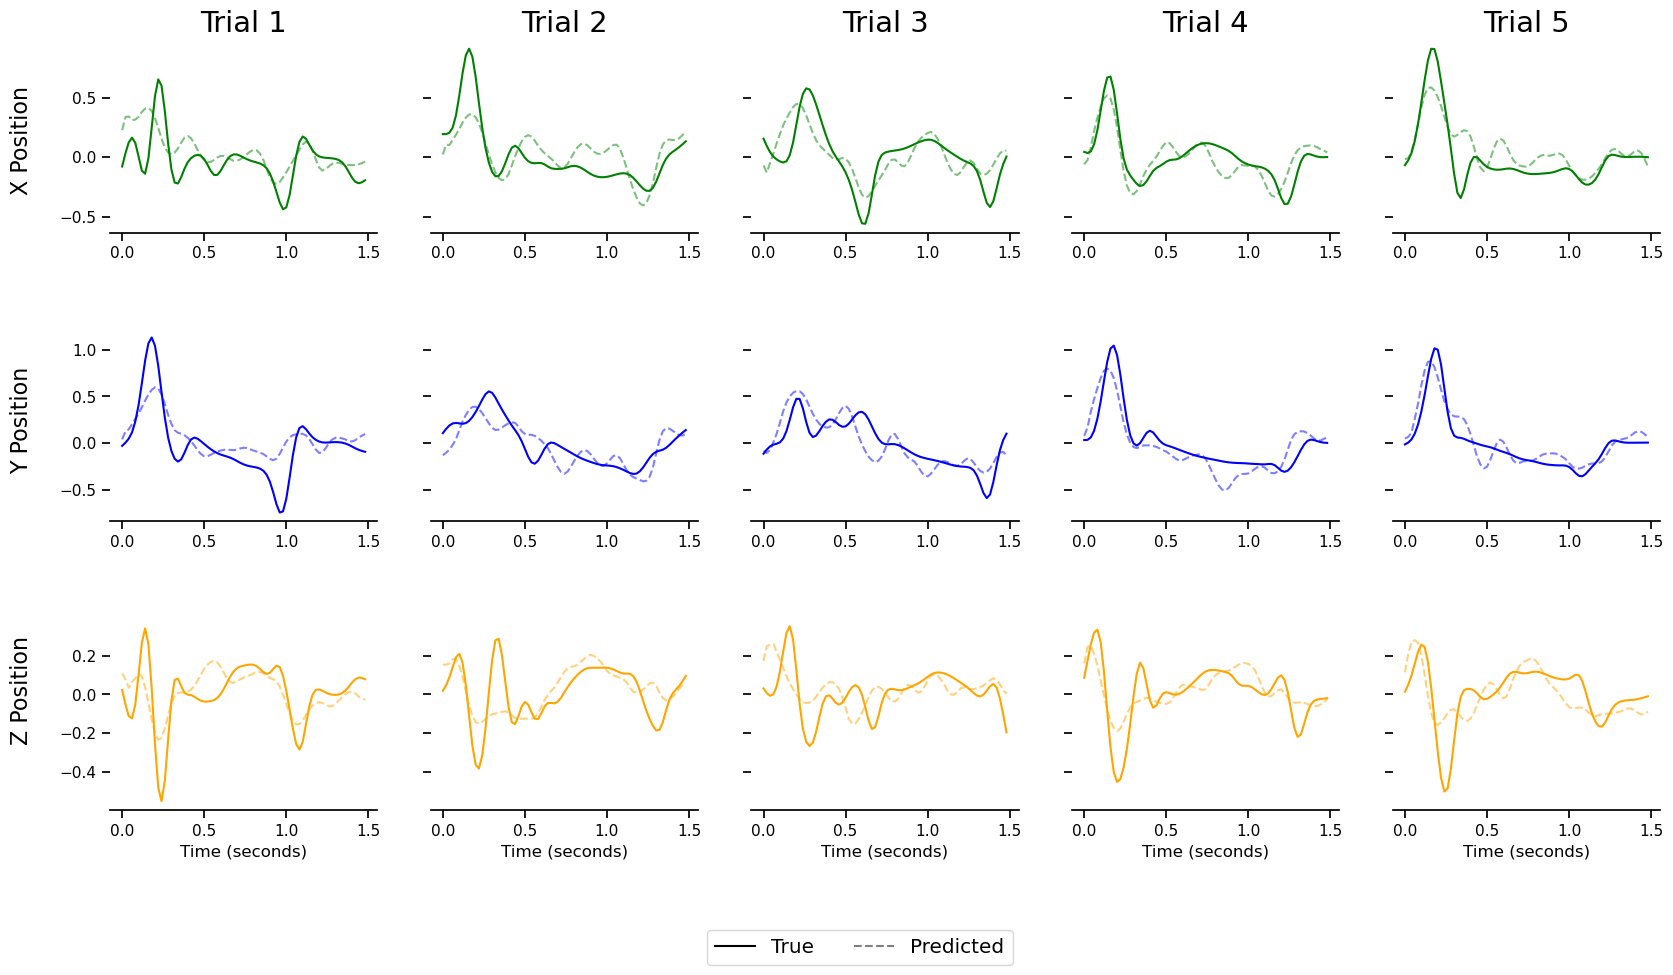

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Implementing EWC

In [ ]:
def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        _loss = fisher[n] * (p - p_old[n]) ** 2
        loss += _loss.sum()
    return loss

In [ ]:
x = to_t_eval(xx_train_base) 
y = to_t_eval(yy_train_base)

/tmp/ipykernel_6594/2062473542.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)


In [ ]:
# Assuming X_train and y_train are NumPy arrays or PyTorch tensors
dataset = list(zip(x, y))

In [ ]:
""" experiment_name_base = 'LSTM_2018'+date+'_Baseline'
path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold)) """


" experiment_name_base = 'LSTM_2018'+date+'_Baseline'\npath_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold)) "

In [ ]:
import copy

In [ ]:
model_baselineonly = copy.deepcopy(model_base)
# Flatten the parameters of the copied model
for module in model_baselineonly.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()
model_baselineonly.train()

Model(
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
params = {n: p for n, p in model_baselineonly.named_parameters() if p.requires_grad}
p_old = {}

for n, p in deepcopy(params).items():
    p_old[n] = p.data

In [ ]:
def get_fisher_diag(model, dataset, params, empirical=True):
 
    fisher = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher[n] = p.data

    
    for input, gt_label in dataset:
        model.zero_grad()
        output = model(input).view(-1)
        if empirical:
            label = gt_label.view(-1)
            
        else:
            label = output.max(1)[1].view(-1)
            

        h_loss  = huber_loss(output, label)
        #negloglikelihood = F.nll_loss(F.log_softmax(output, dim = -1), label)
        #negloglikelihood.backward()
        model.train()
        h_loss.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [ ]:
fisher_matrix = get_fisher_diag(model_baselineonly, dataset, params)

In [ ]:
def train_model_EWC(model, X,Y,
                X_val, 
                Y_val,
                lr=lr, # 0.0001,
                lr_step_size= lr_step_size ,#10,
                lr_gamma=lr_gamma,#0.9,
                sequence_length_LSTM= seq_length_LSTM, #10,
                batch_size_train = batch_size_train, #3,
                batch_size_val = batch_size_val,# 3,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer=None,
                l1_ratio = l1_ratio_reg, #0.5,
                alpha = alpha_reg, #1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=sequence_length_LSTM)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=sequence_length_LSTM)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                X_ = X_.to(device)
                y_ = y_.to(device)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = huber_loss(output_t, y_, delta = delta)
                        
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            ewc_loss = get_ewc_loss(model, fisher_matrix, p_old)
                            loss_t += lambda_ewc * ewc_loss
                        #     loss += regularizer(model, l1_ratio, alpha)
                        # Compute gradients and perform an optimization step
                        loss_t.backward(retain_graph=True)
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = huber_loss(output_t, y_, delta = delta)
                    

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [ ]:
train_losses, val_losses = \
    train_model_EWC(model_baselineonly, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= True,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 0.8
                )


Epoch 000 Train 0.0154 Val 0.0134
Epoch 001 Train 0.0136 Val 0.0126
Epoch 002 Train 0.0124 Val 0.0121
Epoch 003 Train 0.0116 Val 0.0118
Epoch 004 Train 0.0110 Val 0.0116
Epoch 005 Train 0.0104 Val 0.0115
Epoch 006 Train 0.0100 Val 0.0115
Epoch 007 Train 0.0096 Val 0.0116
Epoch 008 Train 0.0092 Val 0.0116
Epoch 009 Train 0.0089 Val 0.0118
Epoch 010 Train 0.0086 Val 0.0118
Epoch 011 Train 0.0084 Val 0.0120
Epoch 012 Train 0.0082 Val 0.0122
Epoch 013 Train 0.0080 Val 0.0123
Epoch 014 Train 0.0079 Val 0.0124
Decrease LR
Epoch 015 Train 0.0077 Val 0.0126
Epoch 016 Train 0.0076 Val 0.0126
Epoch 017 Train 0.0075 Val 0.0127
Epoch 018 Train 0.0074 Val 0.0128
Epoch 019 Train 0.0073 Val 0.0128
Decrease LR


In [ ]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_EWC'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_EWC'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_baselineonly, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [ ]:
""" model_EWC = torch.load(path_to_save_model_fold)
model_EWC.eval() """

' model_EWC = torch.load(path_to_save_model_fold)\nmodel_EWC.eval() '

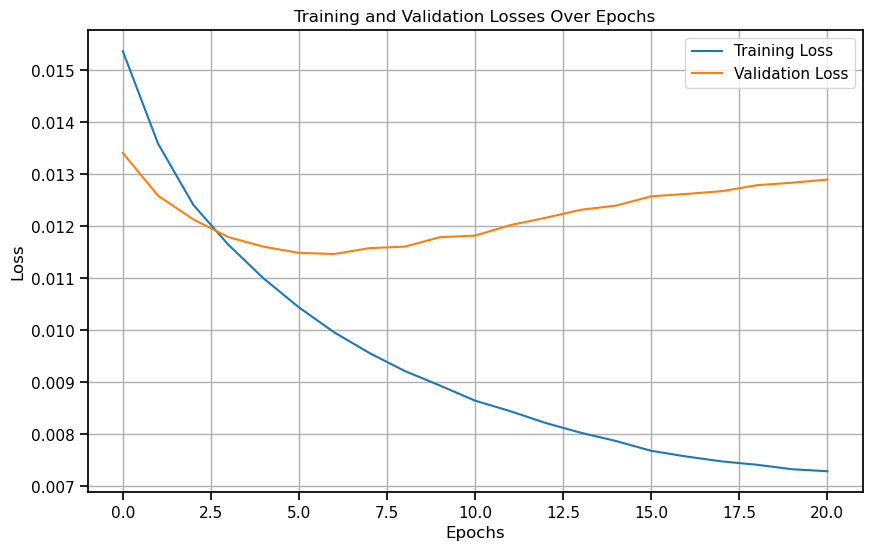

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
model_EWC = copy.deepcopy(model_baselineonly)

# Flatten the parameters of the copied model
for module in model_EWC.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_EWC, metric = 'ev')

Train EV: 0.65 
Val EV: 0.53 
Test EV: 0.54 


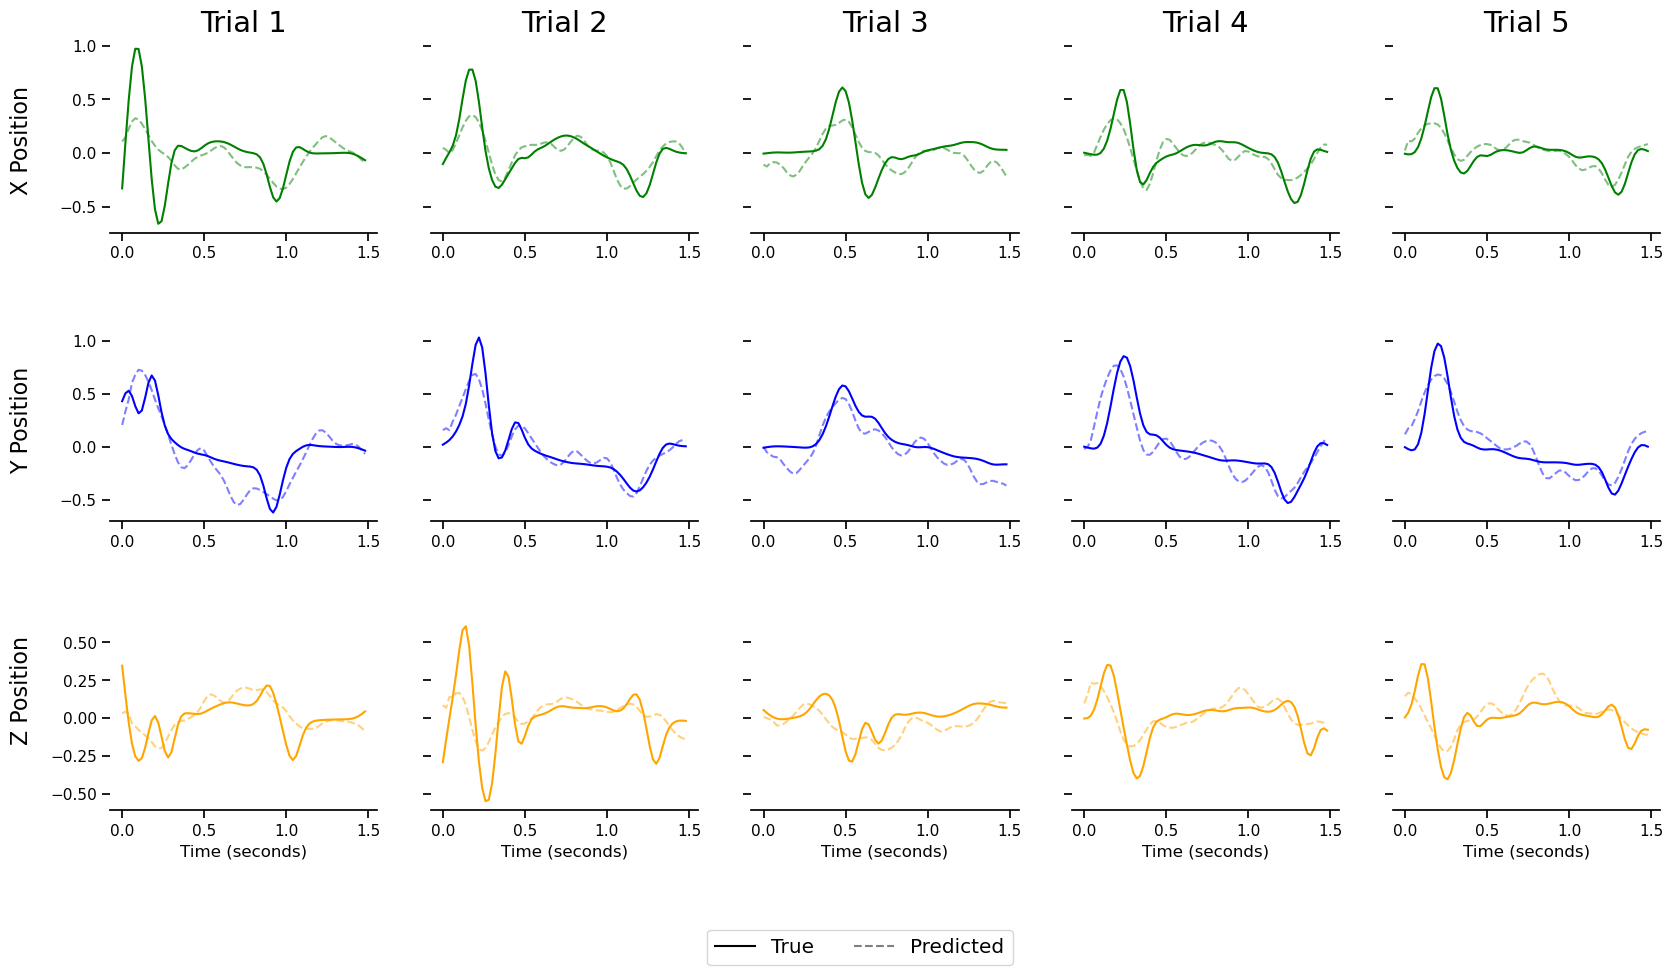

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Testing the performance of the model on Baseline data after EWC

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_EWC, metric = 'ev')

Train EV: 0.49 
Val EV: 0.32 
Test EV: 0.50 


/tmp/ipykernel_6594/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


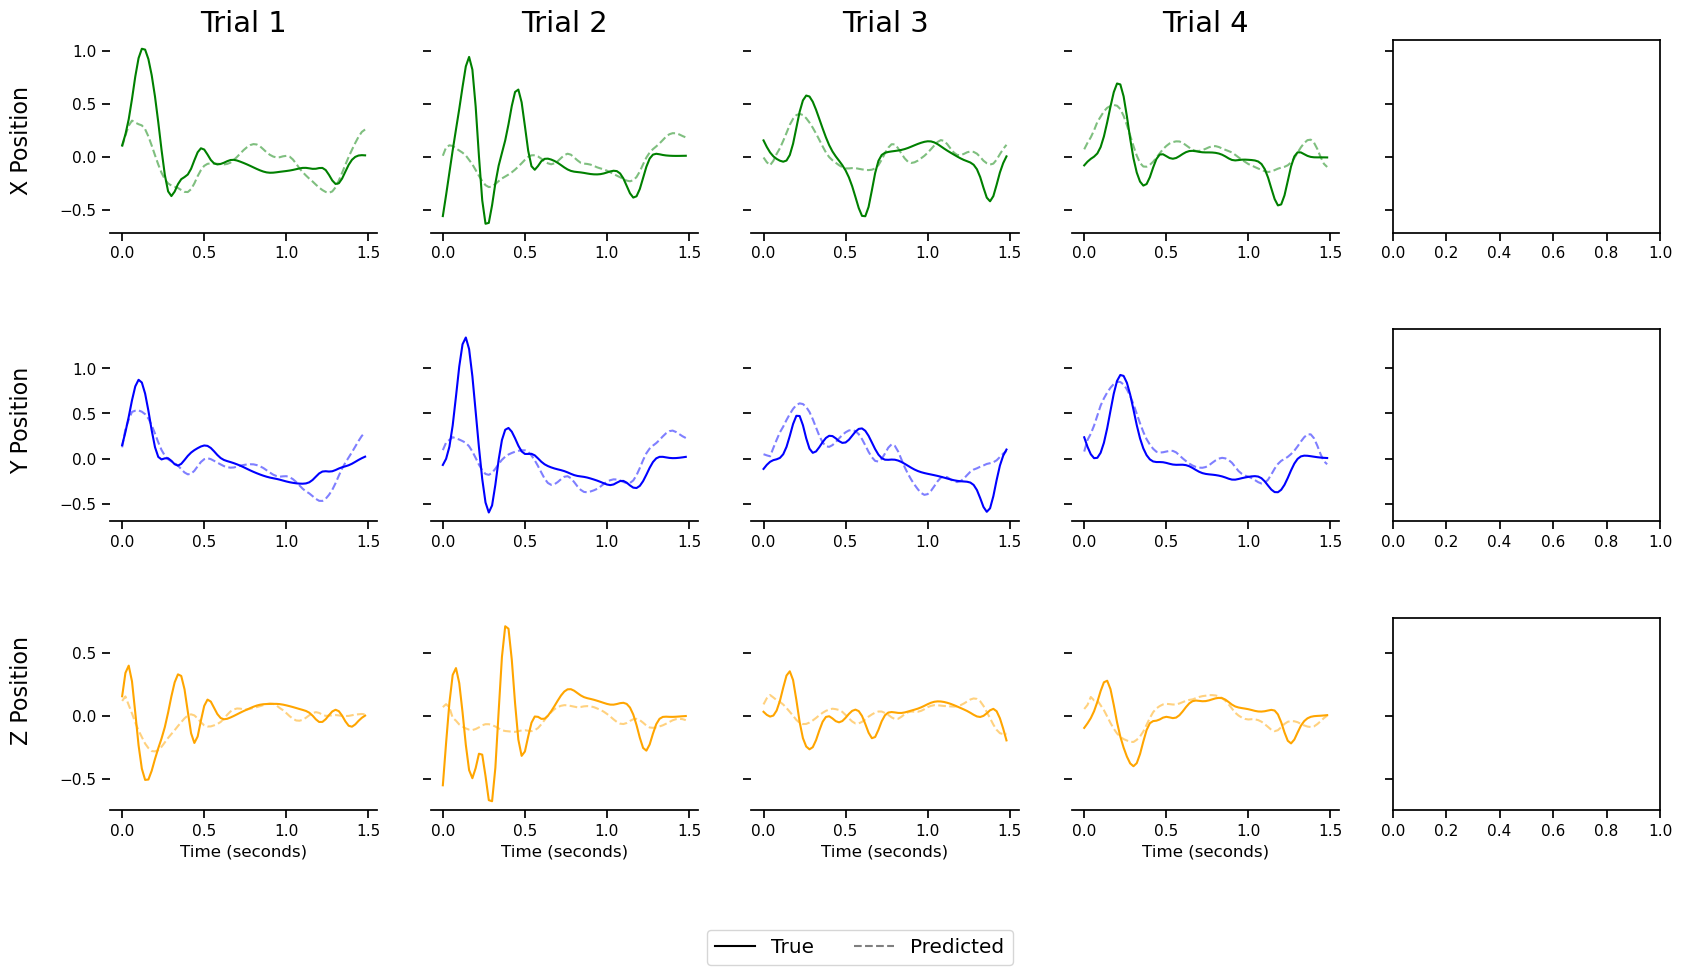

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Training model only on stimulation data and testing on baseline data

In [ ]:
# Fit the LSTM model
model_stim = Model(num_features=num_features, 
                hidden_units= n_hidden_units, #was 128
                num_layers = num_layers, 
                input_size = input_size_LSTM,
                out_dims = num_dim_output).to(device)

def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model_stim.apply(weight_reset)

Model(
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
train_losses, val_losses = \
    train_model(model_stim, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0499 Val 0.0283
Epoch 001 Train 0.0391 Val 0.0232
Epoch 002 Train 0.0342 Val 0.0206
Epoch 003 Train 0.0311 Val 0.0188
Epoch 004 Train 0.0288 Val 0.0177
Epoch 005 Train 0.0268 Val 0.0168
Epoch 006 Train 0.0255 Val 0.0162
Epoch 007 Train 0.0241 Val 0.0157
Epoch 008 Train 0.0229 Val 0.0153
Epoch 009 Train 0.0218 Val 0.0150
Epoch 010 Train 0.0210 Val 0.0148
Epoch 011 Train 0.0200 Val 0.0146
Epoch 012 Train 0.0196 Val 0.0144
Epoch 013 Train 0.0190 Val 0.0143
Epoch 014 Train 0.0182 Val 0.0142
Epoch 015 Train 0.0177 Val 0.0141
Epoch 016 Train 0.0173 Val 0.0140
Epoch 017 Train 0.0168 Val 0.0139
Epoch 018 Train 0.0163 Val 0.0138
Epoch 019 Train 0.0157 Val 0.0137
Epoch 020 Train 0.0154 Val 0.0137
Epoch 021 Train 0.0150 Val 0.0137
Epoch 022 Train 0.0146 Val 0.0136
Epoch 023 Train 0.0144 Val 0.0137
Epoch 024 Train 0.0140 Val 0.0137
Epoch 025 Train 0.0136 Val 0.0137
Epoch 026 Train 0.0134 Val 0.0137
Decrease LR
Epoch 027 Train 0.0131 Val 0.0137
Epoch 028 Train 0.0129 Val 0.0137
Ep

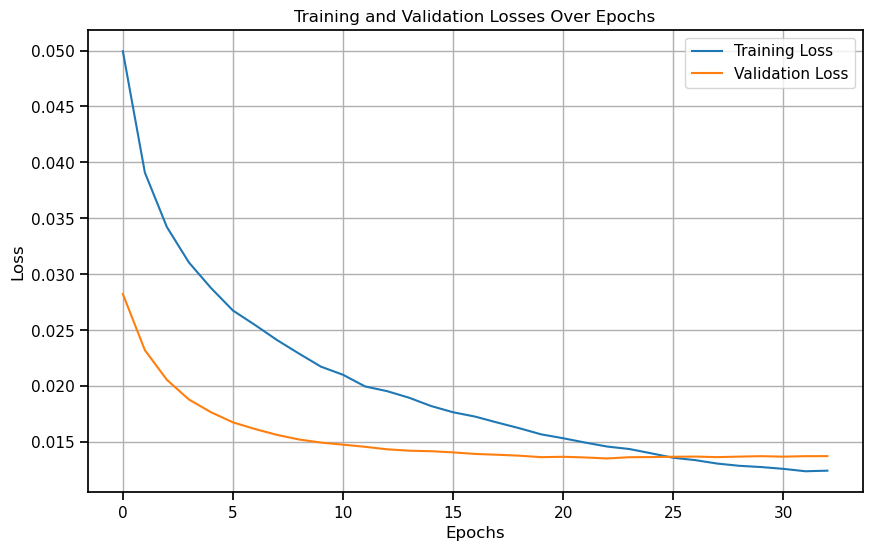

In [ ]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [ ]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stim, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4) """


" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Stimulation'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_stim, path_to_save_model_fold)\ndict_loss = {}\ndict_loss['train'] = train_losses\ndict_loss['val'] = val_losses\npath_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))\nwith open(path_to_save_model_losses, 'wb') as handle:\n    pickle.dump(dict_loss, handle, protocol=4) "

In [ ]:
""" model_stim = torch.load(path_to_save_model_fold)
model_stim.eval() """

' model_stim = torch.load(path_to_save_model_fold)\nmodel_stim.eval() '

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim, metric = 'ev')

Train EV: 0.68 
Val EV: 0.40 
Test EV: 0.47 


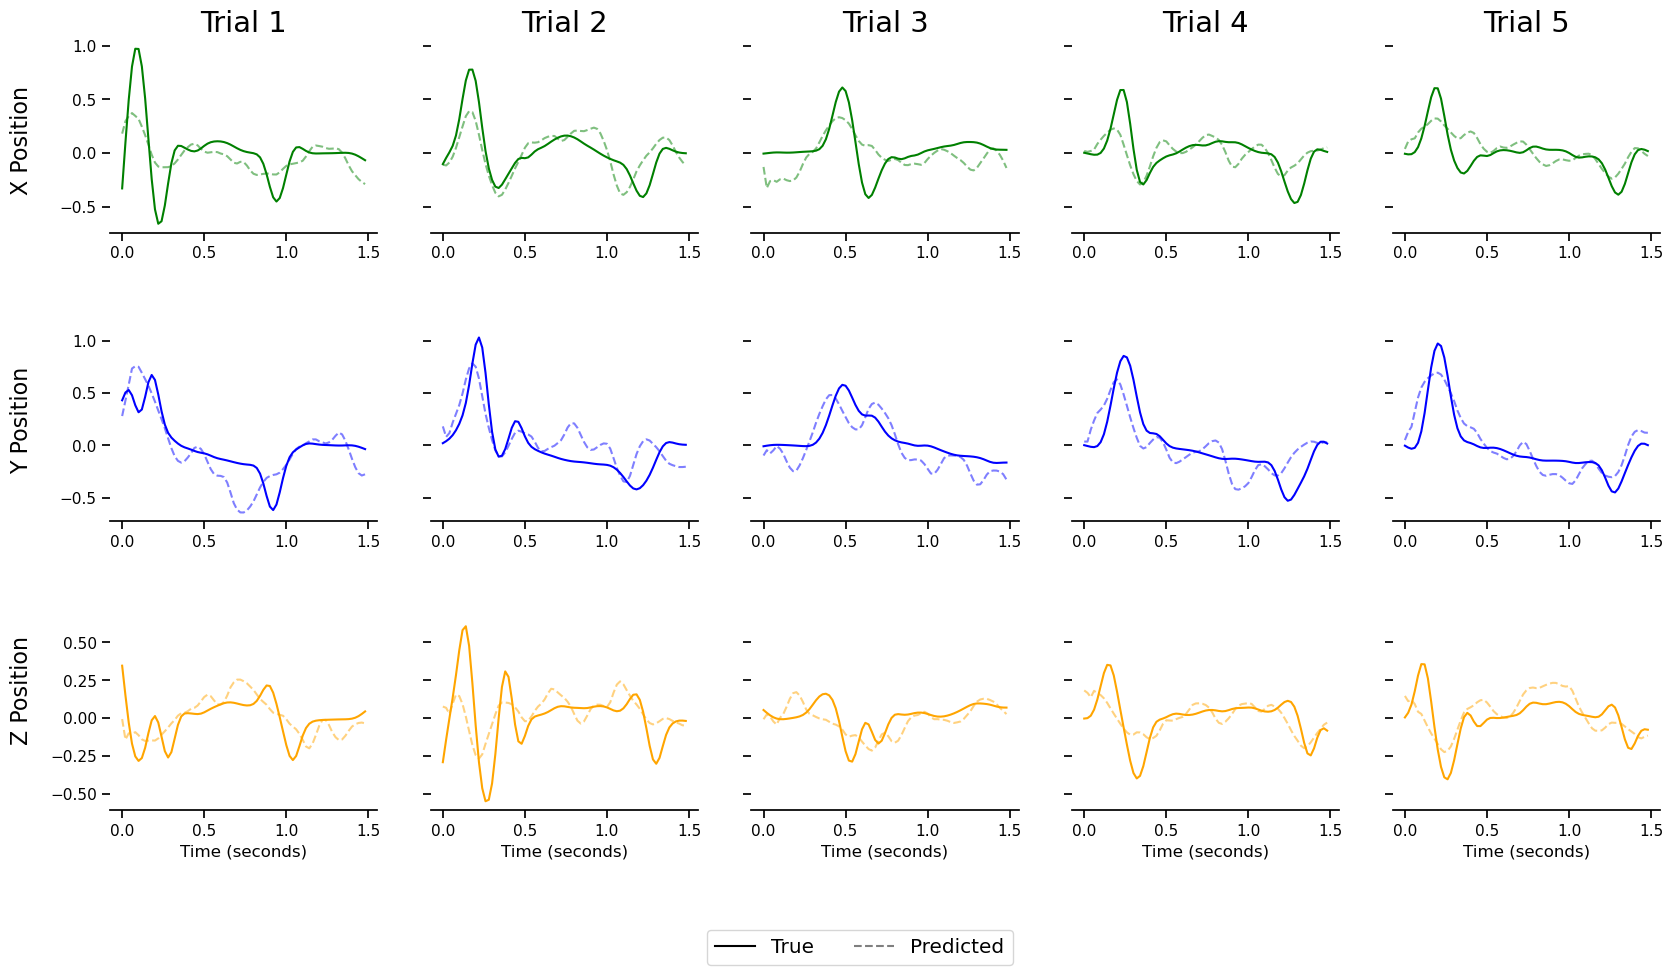

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

### Now test on baseline data to compare to the EWC

In [ ]:
model_stim.eval()

Model(
  (rnn): RNN(128, 150, num_layers=2, batch_first=True)
  (selu): SELU()
  (linear): Linear(in_features=150, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim, metric = 'ev')

Train EV: 0.33 
Val EV: 0.23 
Test EV: 0.40 


/tmp/ipykernel_6594/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


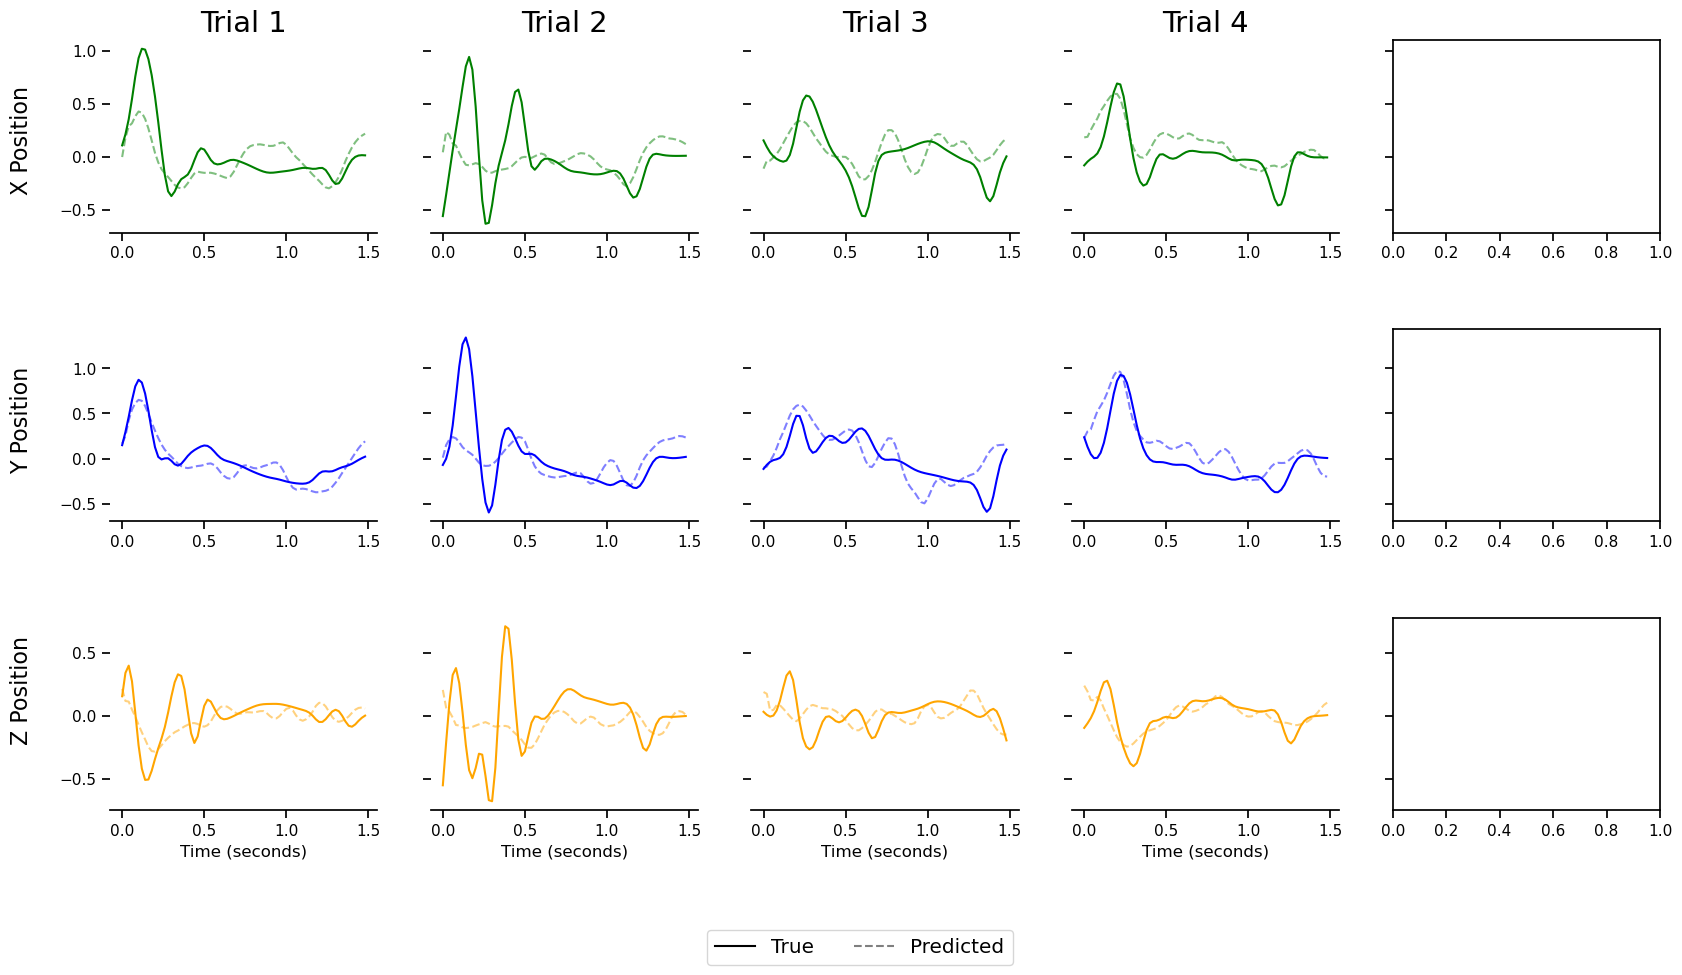

In [ ]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Checking Catastrophic Forgetting

The idea here is to take models trained for one specific task, train them on the other task and then see how they generalize or not.

In [ ]:
path_to_models = './Models'


In [ ]:
""" experiment_name_base = 'LSTM_2018'+date+'_Baseline'
experiment_name_stim= 'LSTM_2018'+date+'_Stimulation' """

" experiment_name_base = 'LSTM_2018'+date+'_Baseline'\nexperiment_name_stim= 'LSTM_2018'+date+'_Stimulation' "

In [ ]:
""" path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))
path_model_stim = os.path.join(path_to_models, experiment_name_stim, 'fold_{}.pth'.format(fold)) """

" path_model_baseline = os.path.join(path_to_models, experiment_name_base, 'fold_{}.pth'.format(fold))\npath_model_stim = os.path.join(path_to_models, experiment_name_stim, 'fold_{}.pth'.format(fold)) "

In [ ]:
""" model_baselineonly = torch.load(path_model_baseline)
model_baselineonly.train() """

' model_baselineonly = torch.load(path_model_baseline)\nmodel_baselineonly.train() '

In [ ]:
""" model_stimonly = torch.load(path_model_stim)
model_stimonly.train() """

' model_stimonly = torch.load(path_model_stim)\nmodel_stimonly.train() '

#### Training on stimulation data using baseline model

In [ ]:
model_stim_after_base  = copy.deepcopy(model_base)

# Flatten the parameters of the copied model
for module in model_stim_after_base.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()

In [ ]:
train_losses, val_losses = \
    train_model(model_stim_after_base, xx_train_stim,yy_train_stim,
                xx_val_stim, 
                yy_val_stim,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0153 Val 0.0135
Epoch 001 Train 0.0135 Val 0.0126
Epoch 002 Train 0.0125 Val 0.0121
Epoch 003 Train 0.0116 Val 0.0117
Epoch 004 Train 0.0109 Val 0.0116
Epoch 005 Train 0.0104 Val 0.0115
Epoch 006 Train 0.0099 Val 0.0115
Epoch 007 Train 0.0096 Val 0.0116
Epoch 008 Train 0.0093 Val 0.0117
Epoch 009 Train 0.0089 Val 0.0117
Epoch 010 Train 0.0087 Val 0.0119
Epoch 011 Train 0.0084 Val 0.0120
Epoch 012 Train 0.0082 Val 0.0122
Epoch 013 Train 0.0080 Val 0.0123
Epoch 014 Train 0.0079 Val 0.0125
Decrease LR
Epoch 015 Train 0.0077 Val 0.0127
Epoch 016 Train 0.0075 Val 0.0126
Epoch 017 Train 0.0074 Val 0.0127
Epoch 018 Train 0.0074 Val 0.0128
Epoch 019 Train 0.0073 Val 0.0128
Decrease LR
6


In [ ]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Stimulation_after_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_baselineonly, path_to_save_model_fold) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Stimulation_after_Baseline'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_baselineonly, path_to_save_model_fold) "

In [ ]:
""" model_stim_after_base = torch.load(path_to_save_model_fold)
model_stim_after_base.eval() """

' model_stim_after_base = torch.load(path_to_save_model_fold)\nmodel_stim_after_base.eval() '

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_stim_after_base, metric = 'ev')

Train EV: 0.49 
Val EV: 0.32 
Test EV: 0.49 


/tmp/ipykernel_6594/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_stim_after_base, metric = 'ev')

Train EV: 0.65 
Val EV: 0.53 
Test EV: 0.54 


#### Training on baseline data using stimulation model

In [ ]:
model_base_after_stim = copy.deepcopy(model_stim)

# Flatten the parameters of the copied model
for module in model_base_after_stim.modules():
    if isinstance(module, nn.RNNBase):
        module.flatten_parameters()

In [ ]:
train_losses, val_losses = \
    train_model(model_base_after_stim, xx_train_base,yy_train_base,
                xx_val_base, 
                yy_val_base,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = huber_delta,                 
                regularizer= None, #Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg,     
                early_stop = 5,
                
                )

/home/nerea/CL_UpperLimb_Control/src/trainer.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


Epoch 000 Train 0.0258 Val 0.0247
Epoch 001 Train 0.0238 Val 0.0241
Epoch 002 Train 0.0227 Val 0.0237
Epoch 003 Train 0.0216 Val 0.0233
Epoch 004 Train 0.0206 Val 0.0233
Epoch 005 Train 0.0200 Val 0.0232
Epoch 006 Train 0.0191 Val 0.0233
Epoch 007 Train 0.0185 Val 0.0234
Epoch 008 Train 0.0181 Val 0.0235
Epoch 009 Train 0.0174 Val 0.0236
Epoch 010 Train 0.0170 Val 0.0237
Epoch 011 Train 0.0166 Val 0.0238
Epoch 012 Train 0.0162 Val 0.0240
Epoch 013 Train 0.0161 Val 0.0241
Epoch 014 Train 0.0154 Val 0.0243
Decrease LR
Epoch 015 Train 0.0153 Val 0.0245
Epoch 016 Train 0.0150 Val 0.0245
Epoch 017 Train 0.0151 Val 0.0246
Epoch 018 Train 0.0148 Val 0.0247
Epoch 019 Train 0.0146 Val 0.0248
Decrease LR
5


In [ ]:
""" path_to_models = './Models'
experiment_name = 'LSTM_2018'+date+'_Baseline_after_Stimulation'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model_stimonly, path_to_save_model_fold) """

" path_to_models = './Models'\nexperiment_name = 'LSTM_2018'+date+'_Baseline_after_Stimulation'\npath_to_save_model = os.path.join(path_to_models,experiment_name)\nif not os.path.exists(path_to_save_model):\n            os.makedirs(path_to_save_model)\npath_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))\ntorch.save(model_stimonly, path_to_save_model_fold) "

In [ ]:
""" model_base_after_stim = torch.load(path_to_save_model_fold)
model_base_after_stim.eval() """

' model_base_after_stim = torch.load(path_to_save_model_fold)\nmodel_base_after_stim.eval() '

In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_stim, yy_train_stim, xx_val_stim, yy_val_stim, xx_test_stim, yy_test_stim, model_base_after_stim, metric = 'ev')

Train EV: 0.58 
Val EV: 0.40 
Test EV: 0.48 


In [ ]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train_base, yy_train_base, xx_val_base, yy_val_base, xx_test_base, yy_test_base, model_base_after_stim, metric = 'ev')

Train EV: 0.53 
Val EV: 0.34 
Test EV: 0.44 


/tmp/ipykernel_6594/2291295100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(x, device=device, dtype=torch.float32)
